$$Model \ Inversion \ Attack - NMNIST - SNN - BrainLeaks$$

# Necessary Imports

In [1]:
!pip install tonic
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 7.2 MB/s eta 0:00:00


In [13]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
from snntorch import spikegen
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import tonic
from dataclasses import dataclass
import tonic.transforms as transforms
from IPython.display import HTML
import torch.nn.functional as F


# Data Preparation

In [3]:
## Define some custom transformations

# This transformation prevents more than one spike per frame.
@dataclass(frozen=True)
class ClampToMaxOne:
    def __init__(self):
        pass

    def __call__(self, frames):
        clamped_frames = torch.clamp(frames, max=1.0)
        return clamped_frames


# This transformation removes one of the polarities to make the data compatible with a fully connected neural network.@dataclass(frozen=True)
class RemovePolarity:
    def __init__(self):
        pass

    def __call__(self, frames):
        dim_frames = frames[:,0,:,:]
        return dim_frames


In [5]:
# Convert DVS data to spiky frames

frame_transform = transforms.Compose([
                                      transforms.Denoise(filter_time=40000),

                                      transforms.ToFrame(sensor_size=(34, 34, 2),
                                                         time_window=3000),

                                      torch.from_numpy,
                                      RemovePolarity(),
                                      ClampToMaxOne()
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./data/NMNIST/test.zip to ./data/NMNIST


In [7]:
# Use Disk Cache for more loading speed

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 100
train_loader = DataLoader(cached_trainset, batch_size=batch_size,drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))

# SNN Target Model

In [8]:


# Network Architecture
num_inputs = 34*34
num_hidden = 3000
num_outputs = 10


# Temporal Dynamics

beta = 0.7  # Leakage (Decay) Factor of LIF Neurons

spike_grad=surrogate.fast_sigmoid(slope=40) # Define the gradient for the surrogate function fast_sigmoid with a slope of 40.


# Other
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky( beta = beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky( beta = beta, spike_grad=spike_grad)

    def forward(self, x):
        # Initialize hidden states + output spike at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # spk2_rec = []
        mem2_rec = []

        for step in range(x.size(0)):
            cur1 = self.fc1(x[step])
            spk1,  mem1 = self.lif1(cur1,  mem1)
            cur2 = self.fc2(spk1)
            spk2,  mem2 = self.lif2(cur2, mem2)

            # spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(mem2_rec, dim=0)

net = Net().to(device)

In [10]:
def print_batch_accuracy(data, targets, train=False):

    output = net(data.view(data.size(0), batch_size, -1))
    idx = output.sum(dim=0).argmax(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    # print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(data_it, targets_it, train=True)
    # print_batch_accuracy(testdata_it, testtargets_it, train=False)
    print("\n")

## Model Training

The state dictionary containing the pre-trained model's learned parameters is saved in **'NMNIST_SNN_Weights_Target'** and can be loaded by running the following cell.

In [11]:
net.load_state_dict(torch.load("NMNIST_SNN_Weights_Target",map_location=torch.device(device)))

<All keys matched successfully>

Following cell contains the training loop. If you have already loaded learned parameters from "NMNIST_SNN_Weights_Target", you don't need to run this cell.

In [ ]:
# Create an Adam optimizer for training the neural network with a specified learning rate and betas.
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))

# Instantiate the log softmax function and the negative log-likelihood loss function.
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()


# Initialize lists to store training and testing loss values.

loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(1): # This is the last epoch just to check the accuracy and loss. Model needs to be trained at least for 20 epoches.
    minibatch_counter = 0
    data = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)
        num_steps=data_it.size(0)



        # Forward pass
        mem_rec = net(data_it.view(num_steps, batch_size, -1))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward() #retain_graph=True
        nn.utils.clip_grad_norm_(net.parameters(), 1)

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())





        ## Uncomment the following command to track the validation accuracy during training.
        ## For less computation, we postpone the evaluation of the model on the validation set until after the training phase.


        ## Test Phase

        # test_data = itertools.cycle(test_loader)
        # testdata_it, testtargets_it = next(test_data)
        # testdata_it = testdata_it.to(device)
        # testtargets_it = testtargets_it.to(device)


        # num_steps_test=testdata_it.size(0)

        ## Test set forward pass
        # ttest_mem_rec = net(testdata_it.view(num_steps_test, batch_size, -1))

        # Test set loss
        # log_p_ytest = log_softmax_fn(test_mem_rec)
        # log_p_ytest = log_p_ytest.sum(dim=0)
        # loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        # test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 100 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

# loss_hist_true_grad = loss_hist
# test_loss_hist_true_grad = test_loss_hist

Epoch 0, Minibatch 0
Train Set Loss: 60.74812698364258
Train Set Accuracy: 0.99


Epoch 0, Minibatch 100
Train Set Loss: 58.281982421875
Train Set Accuracy: 0.99


Epoch 0, Minibatch 200
Train Set Loss: 69.45623016357422
Train Set Accuracy: 0.97


Epoch 0, Minibatch 300
Train Set Loss: 83.14078521728516
Train Set Accuracy: 0.93


Epoch 0, Minibatch 400
Train Set Loss: 67.39185333251953
Train Set Accuracy: 0.94


Epoch 0, Minibatch 500
Train Set Loss: 66.98783874511719
Train Set Accuracy: 0.97




In [ ]:
# torch.save(net.state_dict(), "NMNIST_SNN_Weights_Target") # This code saves the model's parameters

## Model Evaluation

In [12]:
# Evaluation
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        output =  net(data.view(data.size(0), batch_size, -1))
        predicted = output.sum(dim=0).argmax(1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 96.88%


# MI Attacks

## Brain Leaks V1

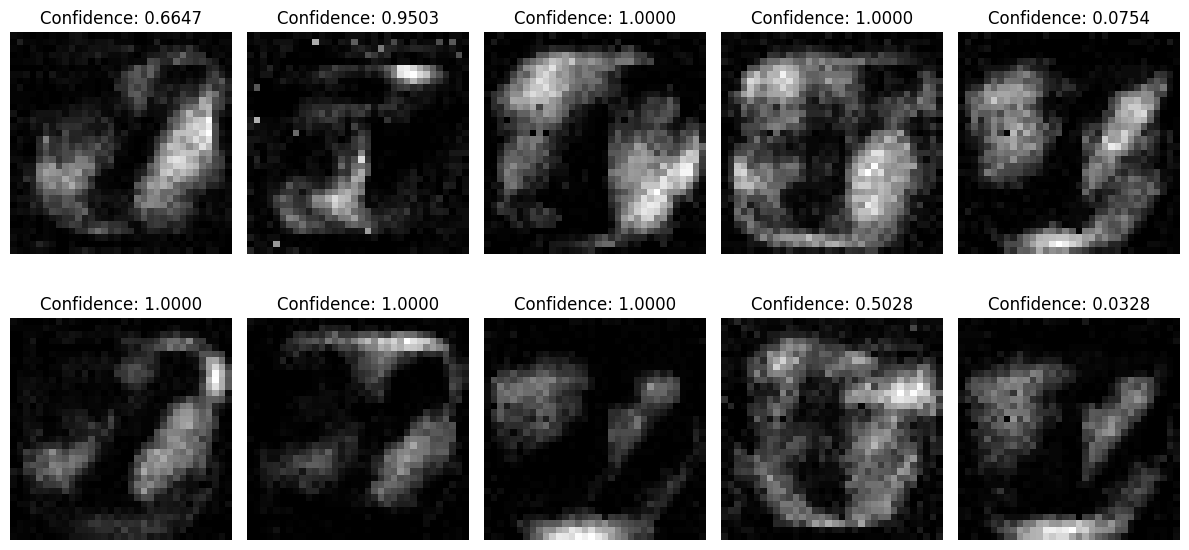

In [61]:
Inverted_Samples_BL1=[]

num_steps=100
# Create subplots for displaying visualizations.
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)

# Loop through each target class
for target_class in range(num_outputs):

    # Initialize spiky input
    spiky_input = torch.zeros((num_steps, 1, num_inputs), requires_grad=True).to(device)

    # Iteratively update spiky input using G2S gradients
    for iteration in range(10):

        # Enable gradient computation for spiky input.
        spiky_input.requires_grad_()
        spiky_input.retain_grad()

        # Calculate the cost by maximizing the softmax output for the target class.
        cost = F.softmax(net(spiky_input).squeeze(1), dim=1).mean(dim=0)[target_class]
        cost.backward()


        with torch.no_grad():

            ## 1. Probabilistic Sampling

            # Calculate the absolute gradient and normalize it.
            grad = spiky_input.grad

            grad_abs = torch.abs(grad)

            min_val = torch.min(grad_abs)
            max_val = torch.max(grad_abs)
            grad_abs_normalized = (grad_abs - min_val) / (max_val - min_val)

            # Normalized Gradients to Binary
            grad_mask = torch.bernoulli(grad_abs_normalized)


            ## 2. Sign Extraction

            grad_mask_sign = torch.sign(grad) * grad_mask




            ## 3. Overflow-Aware Transformation + Update

            # Update the spiky input based on the gradients of G2S method and transform it to avoid overflow
            spiky_input = torch.where(spiky_input + grad_mask_sign > 0, torch.tensor(1, dtype=torch.float32), torch.tensor(0, dtype=torch.float32))

    # Calculate the confidence score for the current target class.
    confidence_score = F.softmax(net(spiky_input).squeeze(1), dim=1).mean(dim=0)[target_class]

    Inverted_Samples_BL1.append(spiky_input)

    ## Plotting Phase

    # Determine the subplot's position in the grid.
    row = target_class // 5
    col = target_class % 5

    # Display the decoded spiky input as an image
    axes[row, col].imshow(torch.sum(spiky_input.detach().cpu(), dim=0).view(34, 34), cmap='gray')
    axes[row, col].set_title(f'Confidence: {confidence_score:.4f}')
    axes[row, col].axis('off')

Inverted_Samples_BL1 = torch.stack(Inverted_Samples_BL1, dim=0)
# Adjust subplot layout and display the figure.
plt.tight_layout()
plt.show()


In [64]:
torch.save(Inverted_Samples_BL1,"NMNIST_SNN_Inverted_BL1")

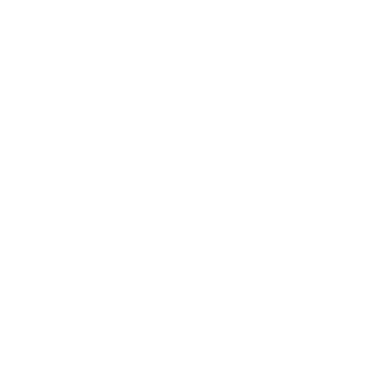

In [18]:
fig, ax = plt.subplots()
anim = splt.animator(Inverted_Samples_BL1[0].detach().view(num_steps,34,34), fig, ax)
HTML(anim.to_html5_video())

## Brain Leaks V2

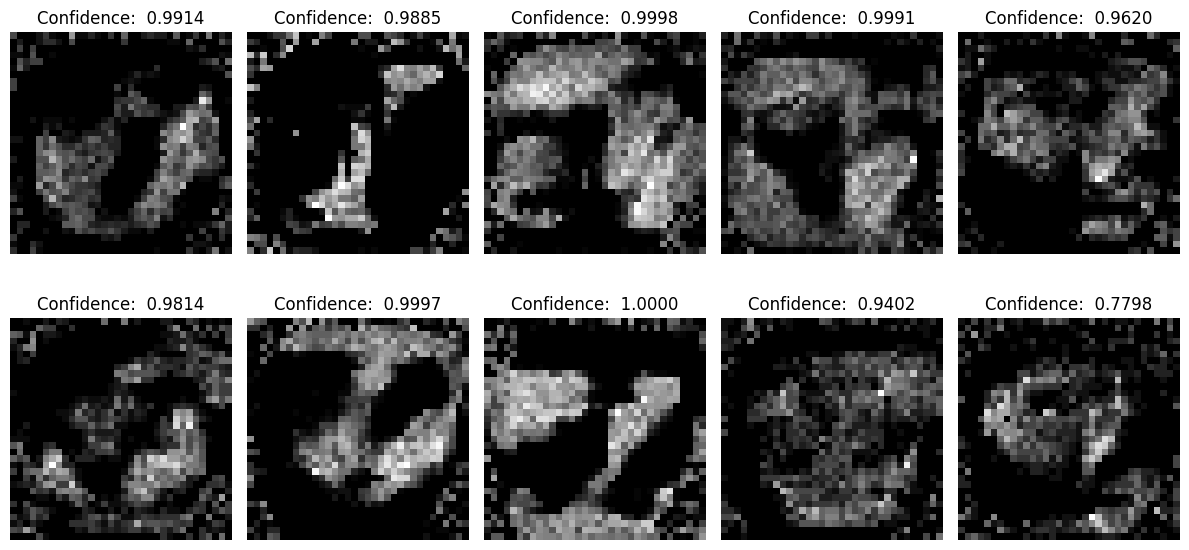

In [14]:
# best
Inverted_Samples_BL2=[]

# Create subplots for displaying visualizations.
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)


# Define hyperparameters for the optimization process.
population=5 # Population size for using Natural Evolution Strategies
learning_rate = 1e-3 # Gradient descent learning rate
momentum = 0.9 # Momentum
epsilon = 1e-12  # Small constant to prevent division by zero in adaptive learning rate
alpha=0.3 # Controls the rate of accumulation of squared gradients in adaptive learning rate calculations
num_steps = 100

# Loop through each target class range(num_outputs)
for target_class in range(num_outputs):

  # Initialize spike probability tensor and create a stack of spiky input tensors.
  spike_probability=torch.zeros((num_steps,1,num_inputs)).to(device)
  spiky_input_stacked=torch.stack([torch.bernoulli(spike_probability) for _ in range(population)]).to(device)

  # Initialize momentum to zero for gradient momentum optimization
  momentum_grad = torch.zeros_like(spike_probability).to(device)

  # Initialize accumulated squared gradients for adaptive learning rate
  squared_grad_sum = torch.zeros_like(spike_probability).to(device)

  # Iteratively update spike probability
  for I in range(10):

    cost_list=[]
    grad_list=[]

    # Iterate through the population of spiky inputs.
    for P in range(population):

      spiky_input=spiky_input_stacked[P]
      spiky_input.requires_grad_()

      # Calculate the cost, including a regularization term.
      cost=-F.log_softmax(net(spiky_input).squeeze(1),dim=1).mean(dim=0)[target_class]+0.3*(spiky_input.sum()/spiky_input.numel())
      cost_list.append(cost)
      cost.backward()
      with torch.no_grad():
        grad=spiky_input.grad
        grad_list.append(grad)

    # Aggregate gradients and perform element-wise multiplication with costs.
    grad_aggregated=torch.zeros((num_steps,1,num_inputs)).to(device)


    with torch.no_grad():

      # Iterate through the lists and perform element-wise multiplication
      for g, c in zip(grad_list, cost_list):
          grad_aggregated += (g * c)/sum(cost_list) # Weighted sum of gradients through the population


      # Calculate adaptive learning rates based on squared gradients
      squared_grad_sum = alpha*squared_grad_sum + (1-alpha)*(grad_aggregated**2)
      adaptive_learning_rate = learning_rate / (torch.sqrt(squared_grad_sum) + epsilon)


      # Update spike_probability using the momentum-aided gradient descent
      momentum_grad = momentum * momentum_grad + grad_aggregated
      spike_probability-=adaptive_learning_rate*momentum_grad

      ## Clamping and ScalingPhase

      spike_probability=torch.where(spike_probability>0,spike_probability,0) ## Min Hard Clamping >> Results in spiky input with higher sparsity

      maxi=spike_probability.max()
      if maxi>1:
        spike_probability= spike_probability/maxi # Max Soft Clamping



      # Generate a stack of spiky inputs based on the updated spike_probability.
      spiky_input_stacked=torch.stack([torch.bernoulli(spike_probability) for _ in range(population)])

  # Calculate the confidence score for the current target class using the one of the generated spiky inputs
  confidence_score=F.softmax(net(spiky_input_stacked[0]).squeeze(1),dim=1).mean(dim=0)[target_class]
  Inverted_Samples_BL2.append(spike_probability)



  ## Plotting Phase

  row = target_class // 5
  col = target_class % 5
  axes[row, col].imshow(torch.sum(spiky_input_stacked[0].detach().cpu(),dim=0).view(34,34),cmap='gray')
  axes[row, col].set_title(f'Confidence: {confidence_score: .4f}')
  axes[row, col].axis('off')

Inverted_Samples_BL2 = torch.stack(Inverted_Samples_BL2, dim=0)
plt.tight_layout()
plt.show()

In [20]:
# torch.save(Inverted_Samples_BL2,"NMNIST_SNN_Inverted_BL2")

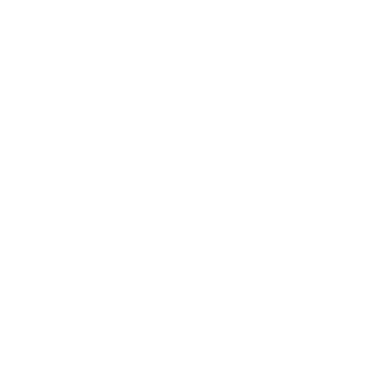

In [17]:
fig, ax = plt.subplots()
anim = splt.animator(torch.bernoulli(Inverted_Samples_BL2[7]).detach().view(num_steps,34,34), fig, ax)
HTML(anim.to_html5_video())

# Evaluation Classifier (Convolutional SNN)

In [25]:
# Network Architecture

num_inputs= 34*34
num_outputs = 10


# Temporal Dynamics
beta=0.8
spike_grad=surrogate.atan(alpha=1.5) # Define the gradient for the surrogate function arc tangent with a slope of 1.5

# Other
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [26]:
#  Initialize Network
eval_net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 24, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(24*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [27]:
def forward_pass(eval_net, data):
  mem_rec = []

  utils.reset(eval_net)  # resets hidden states for all LIF neurons in net
  num_steps = data.size(0)

  for step in range(num_steps):
      _, mem_out = eval_net(data[step].unsqueeze(-3)) # Use unsqueeze for the depth dimention of each frame

      mem_rec.append(mem_out)

  return  torch.stack(mem_rec)

In [33]:
def print_batch_accuracy(data, targets, train=False):


    output = forward_pass(eval_net, data)
    idx = output.sum(dim=0).argmax(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())


    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")


def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    # print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(data_it, targets_it, train=True)
    # print_batch_accuracy(testdata_it, testtargets_it, train=False)
    print("\n")

## Evaluation Classifier Training

The state dictionary containing the pre-trained model's learned parameters is saved in **'NMNIST_SNN_Weights_Eval'** and can be loaded by running the following cell.

In [42]:
eval_net.load_state_dict(torch.load("NMNIST_SNN_Weights_Eval",map_location=device))

<All keys matched successfully>

Following cell contains the training loop. If you have already loaded learned parameters from "NMNIST_SNN_Weights_Eval", you don't need to run this cell.

In [39]:
# Create an Adam optimizer for training the neural network with a specified learning rate and betas.
optimizer = torch.optim.Adam(eval_net.parameters(), lr=5e-5, betas=(0.9, 0.999))


# Instantiate the log softmax function and the negative log-likelihood loss function.
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

# Initialize lists to store training and testing loss values.
loss_hist = []
test_loss_hist = []

counter = 0

# Outer training loop
for epoch in range(1): # This is the last epoch just to check the accuracy and loss. Model needs to be trained at least for 20 epoches.
    minibatch_counter = 0
    data = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)
        num_steps = data_it.size(0)

        # Spike generator
        # spike_data = spikegen.rate(data_it, num_steps)


        # Forward pass
        mem_rec = forward_pass(eval_net, data_it)
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward()
        nn.utils.clip_grad_norm_(eval_net.parameters(), 1)

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())


        ## Uncomment the following command to track the validation accuracy during training.
        ## For less computation, we postpone the evaluation of the model on the validation set until after the training phase.

        ## Test Phase

        # test_data = itertools.cycle(test_loader)
        # testdata_it, testtargets_it = next(test_data)
        # testdata_it = testdata_it.to(device)
        # testtargets_it = testtargets_it.to(device)
        # ## num_steps_test = testdata_it.size(0)


        # # Test set forward pass
        # test_mem_rec = forward_pass(eval_net, testdata_it)

        # # Test set loss
        # log_p_ytest = log_softmax_fn(test_mem_rec)
        # log_p_ytest = log_p_ytest.sum(dim=0)
        # loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        # test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 100 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1


Epoch 0, Minibatch 0
Train Set Loss: 44.65049362182617
Train Set Accuracy: 0.98




In [ ]:
# torch.save(net.state_dict(),'NMNIST_SNN_Weights_Eval')

## Evaluation Classifier Accuracy

In [43]:
# Evaluation
eval_net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        output = forward_pass(eval_net, data.to(device))
        predicted = output.sum(dim=0).argmax(1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 96.58%


# Evaluation Phase

In [44]:
# Function for calculating the accuracy and top-3 accuracy
def count_correct(lst):
    first = 0
    top_3 = 0

    for num in lst:
        # Count the number of occurrences of digit 1
        if num == 1:
          first += 1

        # Count the number of values between 2 and 3 (inclusive)
        if 2 <= num <= 3:
            top_3 += 1

    return first, top_3+first

## Brain Leaks V1

The inverted samples are stored in **"NMNIST_SNN_Inverted_BL1"** and will be loaded at the first line of the following cell. Alternatively, they can be regenerated by running the inversion attack section.

In [65]:
# Import Inverted Samples
Inv_BL1 = torch.load("NMNIST_SNN_Inverted_BL1",map_location=device)

# Inv_BL1 = Inverted_Samples_BL1.clone() # If you already have the inverted samples in your notebook

In [66]:
# Attack Evaluation

conf_mat = F.softmax(forward_pass(eval_net,Inv_BL1.permute(1, 0, 2,3).view([-1,10,34,34])),dim=2).mean(0) # Confidence Matrix
rank_mat = torch.argsort(conf_mat,descending=True) # Ranking Matrix
conf_ranks=[]

for i in range(10):
   conf_ranks.append(torch.where(rank_mat[i]==i)[0].item()+1)

DAA_ranks = conf_mat.argmax(0) # Out of all inverted samples, which one is the most similar to digit X


print("\n ** Predicted Labels  :\n\n",conf_mat.max(1)[1])
print("\n\n ** Predicted Labels Confidence  :\n\n",conf_mat.max(1)[0])

print("\n\n\n ** Ground Truth Ranks in Prediction  :\n\n",conf_ranks)
print("\n\n\n ** Number of corrects (First,Top-3)  :\n\n",count_correct(conf_ranks))

print("\n\n ** Confidences of the correct outputs  :\n\n",torch.diag(conf_mat))

print("\n\n ** DAA Ranks  :\n\n",DAA_ranks) # Out of all inverted samples, which one is the most similar to digit X


 ** Predicted Labels  :

 tensor([2, 8, 2, 8, 8, 2, 2, 3, 8, 8], device='cuda:0')


 ** Predicted Labels Confidence  :

 tensor([0.6790, 0.5163, 0.5326, 0.3682, 0.5216, 0.9251, 0.9258, 0.6579, 0.7070,
        0.4643], device='cuda:0', grad_fn=<MaxBackward0>)



 ** Ground Truth Ranks in Prediction  :

 [4, 4, 1, 2, 4, 6, 5, 7, 1, 5]



 ** Number of corrects (First,Top-3)  :

 (2, 3)


 ** Confidences of the correct outputs  :

 tensor([2.2582e-03, 2.7316e-02, 5.3264e-01, 3.5761e-01, 1.6548e-03, 1.5455e-04,
        3.2812e-04, 2.1990e-04, 7.0704e-01, 3.4573e-04], device='cuda:0',
       grad_fn=<DiagonalBackward0_copy>)


 ** DAA Ranks  :

 tensor([0, 1, 6, 7, 4, 1, 1, 7, 8, 0], device='cuda:0')


In [67]:
print("Attack Accracy:",count_correct(conf_ranks)[0]/10)
print("\n\nTop-3 Attack Accuracy:", count_correct(conf_ranks)[1]/10)
print("\n\n ** Average Confidence of correct outputs",torch.diag(conf_mat).mean().item())
print("\n\nDAA:", (sum(DAA_ranks==torch.tensor(range(10)).to(device)).item())/10)

Attack Accracy: 0.2


Top-3 Attack Accuracy: 0.3


 ** Average Confidence of correct outputs 0.1629563421010971


DAA: 0.5


## Brain Leaks V2

The inverted samples are stored in **"NMNIST_SNN_Inverted_BL2"** and will be loaded at the first line of the following cell. Alternatively, they can be regenerated by running the inversion attack section.

In [72]:
# Import Inverted Samples
Inv_BL2 = torch.load("NMNIST_SNN_Inverted_BL2",map_location=device)

# Inv_BL2 = Inverted_Samples_BL2.clone() # If you already have the inverted samples in your notebook

In [73]:
# Attack Evaluation

conf_mat = F.softmax(forward_pass(eval_net,torch.bernoulli(Inv_BL2).permute(1, 0, 2,3).view([-1,10,34,34])),dim=2).mean(0) # Confidence Matrix
rank_mat = torch.argsort(conf_mat,descending=True) # Ranking Matrix
conf_ranks=[]

for i in range(10):
   conf_ranks.append(torch.where(rank_mat[i]==i)[0].item()+1)

DAA_ranks = conf_mat.argmax(0) # Out of all inverted samples, which one is the most similar to digit X


print("\n ** Predicted Labels  :\n\n",conf_mat.max(1)[1])
print("\n\n ** Predicted Labels Confidence  :\n\n",conf_mat.max(1)[0])

print("\n\n\n ** Ground Truth Ranks in Prediction  :\n\n",conf_ranks)
print("\n\n\n ** Number of corrects (First,Top-3)  :\n\n",count_correct(conf_ranks))

print("\n\n ** Confidences of the correct outputs  :\n\n",torch.diag(conf_mat))

print("\n\n ** DAA Ranks  :\n\n",DAA_ranks) # Out of all inverted samples, which one is the most similar to digit X


 ** Predicted Labels  :

 tensor([0, 8, 3, 3, 8, 3, 6, 3, 8, 8], device='cuda:0')


 ** Predicted Labels Confidence  :

 tensor([0.9515, 0.4355, 0.5543, 0.9829, 0.7052, 0.7097, 0.8280, 0.4194, 0.8660,
        0.6643], device='cuda:0', grad_fn=<MaxBackward0>)



 ** Ground Truth Ranks in Prediction  :

 [1, 2, 2, 1, 3, 4, 1, 2, 1, 2]



 ** Number of corrects (First,Top-3)  :

 (4, 9)


 ** Confidences of the correct outputs  :

 tensor([0.9515, 0.2668, 0.4347, 0.9829, 0.0681, 0.0359, 0.8280, 0.3929, 0.8660,
        0.1733], device='cuda:0', grad_fn=<DiagonalBackward0_copy>)


 ** DAA Ranks  :

 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


In [74]:
print("Attack Accracy:",count_correct(conf_ranks)[0]/10)
print("\n\nTop-3 Attack Accuracy:", count_correct(conf_ranks)[1]/10)
print("\n\n ** Average Confidence of correct outputs",torch.diag(conf_mat).mean().item())
print("\n\nDAA:", (sum(DAA_ranks==torch.tensor(range(10)).to(device)).item())/10)

Attack Accracy: 0.4


Top-3 Attack Accuracy: 0.9


 ** Average Confidence of correct outputs 0.5000152587890625


DAA: 1.0


We generate different versions of the inverted samples through Bernoulli sampling and compute the metrics' statistics:

In [79]:
# Averaging Attack Evaluation for Brain Leaks V2
Acc_list=[]
Top3_list=[]

for i in range(1000):


  conf_mat = F.softmax(forward_pass(eval_net,torch.bernoulli(Inv_BL2).permute(1, 0, 2,3).view([-1,10,34,34])),dim=2).mean(0) # Confidence Matrix
  rank_mat = torch.argsort(conf_mat,descending=True) # Ranking Matrix
  conf_ranks=[]

  for i in range(10):
    conf_ranks.append(torch.where(rank_mat[i]==i)[0].item()+1)
  corrects,top3 = count_correct(conf_ranks)
  Acc_list.append(corrects/10)
  Top3_list.append(top3/10)



In [80]:
print("Mean of Attack Accracy:",np.array(Acc_list).mean())
print("\n\nSTD of Attack Accracy:",np.array(Acc_list).std())

print("\n\nMean of Top-3 Attack Accuracy:", np.array(Top3_list).mean())
print("\n\nSTD of Top-3 Attack Accuracy:", np.array(Top3_list).std())


Mean of Attack Accracy: 0.46120000000000005


STD of Attack Accracy: 0.0656853103821547


Mean of Top-3 Attack Accuracy: 0.9112000000000001


STD of Top-3 Attack Accuracy: 0.05435586444901781
